<a href="https://colab.research.google.com/github/manansheel1991/Melanoma_Classification_Transfer_Learning/blob/master/Final_Tested_Melanoma_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

In [1]:
import os
import numpy as np
import requests
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Naming the Directories

In [3]:
data_dir='/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data'
train_dir='/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/train'
test_dir='/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test'
valid_dir='/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/valid'

ground_truth = pd.read_csv('/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/ground_truth.csv')


Pre-processing the data

In [4]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
                    
}
train_data= datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_data= datasets.ImageFolder(test_dir, transform=data_transforms['test'])
valid_data= datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])

dataloaders={ 'train' : torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=8, shuffle=True),
              'valid' : torch.utils.data.DataLoader(valid_data,batch_size=32, num_workers=8,shuffle=False),
              'test'  : torch.utils.data.DataLoader(test_data,batch_size=32,num_workers=8,shuffle=False)
    
}

Loading a pre-trained VGG Model and replacing its fully-connected layers with the layers such that we have 3 output classes. This is the step where we are using Transfer Learning

In [5]:
VGG16 = models.vgg16(pretrained=True)

# print(VGG16)

our_model = VGG16

# Replacing the last layer of the classifier with a linear fully-connected layer

our_model.classifier[6] = nn.Linear(4096, 3)

# Freezing the feature parameters

for param in our_model.features.parameters():
    param.requires_grad = False

print(our_model)

classifier_parameters = our_model.classifier.parameters()

# Setting requires_grad to be true for classifier layers, because they have to be trained

for param in classifier_parameters:
    param.requires_grad = True

is_cuda = torch.cuda.is_available()   

if is_cuda:
    our_model = our_model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Specifying the optimizer for the classifier layers, and the loss for the network

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(our_model.classifier.parameters(), lr=0.0001)

In [ ]:
## number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    our_model.train()
    for batch_idx, (data, target) in enumerate(dataloaders['train']):
        # move tensors to GPU if CUDA is available
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = our_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    our_model.eval()
    for batch_idx, (data, target) in enumerate(dataloaders['valid']):
        # move tensors to GPU if CUDA is available
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = our_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(dataloaders['train'].dataset)
    valid_loss = valid_loss/len(dataloaders['valid'].dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    

    torch.save(our_model.state_dict(), 'our_model_2.pt')  
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
       # model_name=  "model_with_loss=_"+str(valid_loss)+".pt"
        torch.save(our_model.state_dict(), 'our_model_2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.748276 	Validation Loss: 0.859718
Validation loss decreased (inf --> 0.859718).  Saving model ...
Epoch: 2 	Training Loss: 0.689030 	Validation Loss: 0.808710
Validation loss decreased (0.859718 --> 0.808710).  Saving model ...
Epoch: 3 	Training Loss: 0.664220 	Validation Loss: 0.781760
Validation loss decreased (0.808710 --> 0.781760).  Saving model ...
Epoch: 4 	Training Loss: 0.622577 	Validation Loss: 0.841554
Epoch: 5 	Training Loss: 0.635062 	Validation Loss: 0.793774
Epoch: 6 	Training Loss: 0.608022 	Validation Loss: 0.733877
Validation loss decreased (0.781760 --> 0.733877).  Saving model ...
Epoch: 7 	Training Loss: 0.590897 	Validation Loss: 0.733843
Validation loss decreased (0.733877 --> 0.733843).  Saving model ...
Epoch: 8 	Training Loss: 0.564457 	Validation Loss: 0.699192
Validation loss decreased (0.733843 --> 0.699192).  Saving model ...
Epoch: 9 	Training Loss: 0.576184 	Validation Loss: 0.797905
Epoch: 10 	Training Loss: 0.554349 	Valida

In [7]:
torch.load('/content/drive/My Drive/Skin Cancer Project/our_model.pt')
state_dict = our_model.state_dict()

In [8]:
our_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#Testing the model

classes=["melanoma","nevus","seborrhic keratosis"]

# monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

our_model.eval()
for batch_idx, (data, target) in enumerate(dataloaders['test']):
    if is_cuda:
        data, target = data.cuda(), target.cuda()
    output = our_model(data)
    loss = criterion(output, target)
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    pred = output.data.max(1, keepdim=True)[1]
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
    if batch_idx % 5 == 0:
      print('Batch ID:', batch_idx)
        
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))


Batch ID: 0
Batch ID: 5
Batch ID: 10
Batch ID: 15
Test Loss: 0.829935


Test Accuracy: 68% (413/600)


Displaying a sample each of the 3 classes, taken from the test set

Text(0.5, 1.0, 'Seborrheic Keratosis Image from the test set')

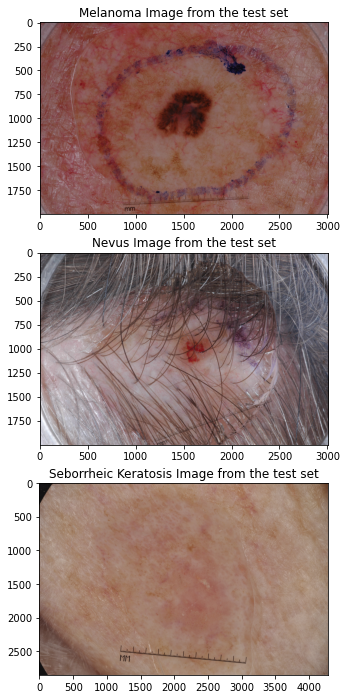

In [9]:
from PIL import Image

img_m = Image.open('/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/melanoma/ISIC_0013678.jpg')
img_n = Image.open('/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/nevus/ISIC_0012149.jpg')
img_sk = Image.open('/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/seborrheic_keratosis/ISIC_0012240.jpg')

plt.figure(figsize=(12,12))

plt.subplot(3,1,1)

plt.imshow(img_m)

plt.title('Melanoma Image from the test set')

plt.subplot(3,1,2)

plt.imshow(img_n)

plt.title('Nevus Image from the test set')

plt.subplot(3,1,3)

plt.imshow(img_sk)

plt.title('Seborrheic Keratosis Image from the test set')


In [10]:
sample_test_file = (dataloaders['test'].dataset[5][0])
sample_test_file_target = (dataloaders['test'].dataset[5][1])

Function to normalize test image to feed into the model

In [16]:
def Normalize(img_path):
    image_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    image = image_transform(Image.open(img_path))
    image = image.unsqueeze(0)
    return image

List of class names

In [17]:
classes=["melanoma","nevus","seborrhic keratosis"]

Function to predict cancer type

In [26]:
def cancer_type(img_path):
  image = Normalize(img_path)
  model_output = our_model.forward(image.cuda())
  model_output = model_output.cpu().detach().numpy().argmax()
  cancer_class = classes[model_output]
  return cancer_class


Testing the function on examples from test set

In [37]:
img_path_melanoma_example = '/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/melanoma/ISIC_0013588.jpg'
m = cancer_type(img_path_melanoma_example)
print(m)

img_path_nevus_example = '/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/nevus/ISIC_0016072.jpg'
n = cancer_type(img_path_nevus_example)
print(n)
img_path_sk_example = '/content/drive/My Drive/Skin Cancer Project/dermatologist-ai/full data/test/seborrheic_keratosis/ISIC_0014653.jpg'
s = cancer_type(img_path_sk_example)
print(s)

melanoma
nevus
seborrhic keratosis
